In [41]:
#rootf = NAME_FOLDER_RBM-MHC ## name of the folder where RBM-MHC is saved ##
rootf = '/home/barbara/rbm-mhc'
### Inclusions ###
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Garuda']
mpl.rcParams['font.serif'] = ['Garuda-Oblique']
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pandas as pd

1. Evaluating AUC and PPV of RBM-MHC prediction of antigens from Sarkizova et al. 2020

In [ ]:
out_fold = rootf + '/data/Allele-specific_models/Allele-specific_Sarkizova2020/Results_plot/'

## Read the output of RBM-MHC and estimate the PPV and AUC##

filehla = out_fold + 'hla_fin.txt'
hlas0 = []
with open(filehla) as f:
	for line in f:
		linesplit = line.strip().split('\n')
		hlas0.append(linesplit[0])  
hlas=list(np.unique(hlas0))


for tp in [0.1,1]:

    if tp == 1:
        ind_th = np.loadtxt(out_fold + 'index_th1.txt').astype(int)

    ## choose threshold ##
    if tp == 0.1:
        ind_th = list(np.arange(0,100000))

    print(len(ind_th))

    PPV_rbm=[]
    tpr_rbm=[]
    fpr_rbm=[]
    auc_rbm=[]

    tr_zero = np.zeros((len(hlas)))
    cou_rbm=[]
    dist=[]
    N2l=[]
    N0l=[]

    hla_better=[]
    false_pos_better=[]
    false_pos_ranks_better=[]
    improvement=[]
    true_pos_better=[]
    true_pos_ranks_better=[]
    
    tr_nm_pos=[]
    tr_nm_neg=[]
    
    for y in range(len(hlas)):

        hh = hlas[y]
        h2 = hh.replace('*','')
        
        tab = pd.read_csv(rootf + '/data/Allele-specific_models/Allele-specific_Sarkizova2020/mono_' + hh  + '/scoring/peptides-to-score_scored_YesReal_0_hu_5_l120.001_AL9.5_SA9_RWNoAlpha_TR1.txt', sep='\t')
        seqs = (tab['Sequences'].values)[:100]
        seqs_all = (tab['Sequences'].values)
        
        ranks = tab['RBM Log-Lik.'].values
        ranks = ranks[ind_th]
        Meff = len(ranks)
        RBMn = round(Meff/100*tp)
        pred = (np.sort(ranks)[::-1])[RBMn] ## find the threshold between top 0.1 and rest in scores

        top100 = ranks[:100] ## look at scores assigned to the true positives
        ppv_r = 0
        for t in top100:
            if t > pred:
                #print(t)
                ppv_r += 1 ## count how many true positives would be predicted

        PPV_rbm.append(ppv_r/100) ## divide by the full number of true positives

        if tp==0.1:
            labels = np.hstack((np.ones(100), np.zeros(99900)))
        if tp==1:
            labels = np.hstack((np.ones(100), np.zeros(9900))) 
        scores = np.hstack((ranks[:100], ranks[100:]))
        fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
        tt = np.argmin(abs(thresholds - pred))
        if y == 16:
            fpr_rbmc = np.array(fpr)
            tpr_rbmc = np.array(tpr)
            th_rbm_fin = thresholds[tt]
            ranks_rbm_fin = np.copy(ranks)
            fpr_rbm.append(fpr[tt])
            tpr_rbm.append(tpr[tt])
        auc_rbm.append(metrics.auc(fpr, tpr))
        
    if tp == 0.1:
        PPV_rbm01 = list(PPV_rbm)
        th_rbm_fin01 = th_rbm_fin
        ranks_rbm_fin01 = list(ranks_rbm_fin)
        fpr_rbm01=fpr_rbm
        tpr_rbm01=tpr_rbm    

#np.savetxt(out_fold + 'PPV_rbm01.txt', PPV_rbm01)
#np.savetxt(out_fold + 'PPV_rbm.txt', PPV_rbm )
#np.savetxt(out_fold + 'auc_rbm.txt', auc_rbm)

## upload results from NetMHCpan4.0##

PPV_NMr01 = np.loadtxt(out_fold + 'PPV_NMr01.txt')
PPV_NMr = np.loadtxt(out_fold + 'PPV_NMr.txt')
auc_nm = np.loadtxt(out_fold + 'auc_nm.txt')
dist = np.loadtxt(out_fold + 'dist.txt')


## Figure 1D ##
listp = [0, 0.054, 0.1, 0.165]
list_ppv_rbm=[]
list_ppv_nm=[]
list_auc_rbm=[]
list_auc_rbm_err=[]
list_auc_nm=[]
lenn=[]
n=-1
for pp in range(len(listp)):
    llr = []
    lln = []
    aan = []
    aar = []
    for d in range(len(dist)):
        if n < dist[d] <= listp[pp]:
            lln.append(PPV_NMr[d])
            llr.append(PPV_rbm[d])
            aar.append(auc_rbm[d])
            aan.append(auc_nm[d])
    lenn.append(len(lln))
    
    n = listp[pp]
    
    list_ppv_nm.append(np.median(lln))
    list_ppv_rbm.append(np.median(llr))
    
    list_auc_nm.append(np.mean(aan))
    list_auc_rbm.append(np.mean(aar))
    list_auc_rbm_err.append(np.std(aar))
    
name_dist='Distance from NetMHC training HLA data'
name_nm = 'NetMHCpan4.0'
name_rbm = 'RBM-MHC'

name_tech = 'PPV'
list_dis = ['0','0-0.05','0.05-0.1','0.1-0.17']
indi = np.argsort(dist)
dists=[]
for u in range(len(list_dis)):
    dists = dists + list(np.repeat([list_dis[u]],lenn[u]))


fig, axes = plt.subplots(1,2)
fig.set_figwidth(13)
fig.set_figheight(4.5)
fig.subplots_adjust(wspace=0.25)
st=14
aa=0.35
s2=18

ax=axes[0]
ax1=ax
datao = {name_tech: [auc_nm[i] for i in indi] + [auc_rbm[i] for i in indi],
         name_dist: dists+dists,
        'Algorithm': list(np.repeat([name_nm, name_rbm],len(PPV_NMr)))
        }
df = pd.DataFrame (datao, columns = [name_tech,name_dist,'Algorithm'])
df_binned = df;
datao = {name_tech: [auc_nm[i] for i in indi] + [auc_rbm[i] for i in indi],
         name_dist: [dist[i] for i in indi] + [dist[i] for i in indi],
        'Algorithm': list(np.repeat([name_nm, name_rbm],len(PPV_NMr)))
        }
df = pd.DataFrame (datao, columns = [name_tech,name_dist,'Algorithm'])

ax.scatter(df[df['Algorithm']== name_nm][name_dist].values, df[df['Algorithm']== name_nm][name_tech].values, 
           c = 'DarkGoldenRod', alpha = aa)

ax.scatter(df[df['Algorithm']== name_rbm][name_dist].values, df[df['Algorithm']== name_rbm][name_tech].values, 
           c = 'Maroon', alpha = aa)
ax.axvline(x = 0.05, c = 'k', linestyle='--', linewidth = 0.5)
ax.axvline(x = 0.1, c = 'k', linestyle='--', linewidth = 0.5)
ax.axvline(x = 0, c = 'k', linestyle='--', linewidth = 0.5)

df1 = df_binned[df_binned['Algorithm'] == name_nm]
listy_nm=[]
for y in range(len(list_dis)):
    listy_nm.append(np.mean(df1[df1[name_dist] == list_dis[y]]['PPV'].values))
    
df1 = df_binned[df_binned['Algorithm'] == name_rbm]
listy_rbm=[]
for y in range(len(list_dis)):
    listy_rbm.append(np.mean(df1[df1[name_dist] == list_dis[y]]['PPV'].values))

listx=[0,0.025,0.075,0.135]
ax.plot(listx, listy_rbm, c = 'Maroon', linewidth= 4)
ax.scatter(listx, listy_rbm, c = 'Maroon', s = 100, marker = 's', label=name_rbm)

ax.plot(listx,listy_nm, c = 'DarkGoldenRod', linewidth= 4)
ax.scatter(listx,listy_nm, c = 'DarkGoldenRod', s = 100, marker = 's', label=name_nm)

ax.set_xlim([-0.01,0.171])
ax.set_ylim([0.67,1.05])
ax.legend(fontsize=s2,loc = 'upper left', bbox_to_anchor=(0.6, 1.2))
ax.tick_params(axis='both', which='major', labelsize=s2)
ax.set_ylabel('AUC', fontsize=s2)
ax.set_xlabel(name_dist, fontsize=s2)
listxx=[0.01, 0.2, 0.47, 0.885]
for t in range(4):
    textst = '(n=' + str(int(lenn[t])) + ')'
    ax.text(listxx[t], 0.01, textst, transform=ax.transAxes, fontsize=st-2, verticalalignment='bottom')

ax=axes[1]
ax1=ax

datao = {name_tech: [PPV_NMr[i] for i in indi] + [PPV_rbm[i] for i in indi],
         name_dist: dists+dists,
        'Algorithm': list(np.repeat([name_nm, name_rbm],len(PPV_NMr)))
        }

df = pd.DataFrame (datao, columns = [name_tech,name_dist,'Algorithm'])
df_binned = df;
datao = {name_tech: [PPV_NMr[i] for i in indi] + [PPV_rbm[i] for i in indi],
         name_dist: [dist[i] for i in indi] + [dist[i] for i in indi],
        'Algorithm': list(np.repeat([name_nm, name_rbm],len(PPV_NMr)))
        }
df = pd.DataFrame (datao, columns = [name_tech,name_dist,'Algorithm'])

ax.scatter(df[df['Algorithm']== name_nm][name_dist].values, df[df['Algorithm']== name_nm][name_tech].values, 
           c = 'DarkGoldenRod', alpha = aa)

ax.scatter(df[df['Algorithm']== name_rbm][name_dist].values, df[df['Algorithm']== name_rbm][name_tech].values, 
           c = 'Maroon', alpha = aa)
ax.axvline(x = 0.05, c = 'k', linestyle='--', linewidth = 0.5)
ax.axvline(x = 0.1, c = 'k', linestyle='--', linewidth = 0.5)
ax.axvline(x = 0, c = 'k', linestyle='--', linewidth = 0.5)

df1 = df_binned[df_binned['Algorithm'] == name_nm]
listy_nm=[]
for y in range(len(list_dis)):
    listy_nm.append(np.mean(df1[df1[name_dist] == list_dis[y]]['PPV'].values))
    
df1 = df_binned[df_binned['Algorithm'] == name_rbm]
listy_rbm=[]
for y in range(len(list_dis)):
    listy_rbm.append(np.mean(df1[df1[name_dist] == list_dis[y]]['PPV'].values))

ax.plot(listx,listy_nm, c = 'DarkGoldenRod', linewidth= 4)
ax.scatter(listx,listy_nm, c = 'DarkGoldenRod', s = 100, marker = 's')

ax.plot(listx,listy_rbm, c = 'Maroon', linewidth= 4)
ax.scatter(listx,listy_rbm, c = 'Maroon', s = 100, marker = 's')

ax.set_xlim([-0.01,0.171])
ax.set_ylim([0.15,0.95])
ax.tick_params(axis='both', which='major', labelsize=s2)
ax.set_ylabel('PPV (top 1%)', fontsize=s2)

axin1 = ax.inset_axes([0.65, 0.7, 0.5, 0.5]) 
ax = axin1
datao = {name_tech: [PPV_NMr01[i] for i in indi] + [PPV_rbm01[i] for i in indi],
         name_dist: dists+dists,
        'Algorithm': list(np.repeat([name_nm, name_rbm],len(PPV_NMr)))
        }
df = pd.DataFrame (datao, columns = [name_tech,name_dist,'Algorithm'])
df_binned = df;
datao = {name_tech: [PPV_NMr01[i] for i in indi] + [PPV_rbm01[i] for i in indi],
         name_dist: [dist[i] for i in indi] + [dist[i] for i in indi],
        'Algorithm': list(np.repeat([name_nm, name_rbm],len(PPV_NMr)))
        }
df = pd.DataFrame (datao, columns = [name_tech,name_dist,'Algorithm'])

ax.scatter(df[df['Algorithm']== name_nm][name_dist].values, df[df['Algorithm']== name_nm][name_tech].values, 
           c = 'DarkGoldenRod', alpha = aa,s=20)

ax.scatter(df[df['Algorithm']== name_rbm][name_dist].values, df[df['Algorithm']== name_rbm][name_tech].values, 
           c = 'Maroon', alpha = aa,s=20)
ax.axvline(x = 0.05, c = 'k', linestyle='--', linewidth = 0.5)
ax.axvline(x = 0.1, c = 'k', linestyle='--', linewidth = 0.5)
ax.axvline(x = 0, c = 'k', linestyle='--', linewidth = 0.5)

df1 = df_binned[df_binned['Algorithm'] == name_nm]
listy_nm=[]
for y in range(len(list_dis)):
    listy_nm.append(np.mean(df1[df1[name_dist] == list_dis[y]]['PPV'].values))
    
df1 = df_binned[df_binned['Algorithm'] == name_rbm]
listy_rbm=[]
for y in range(len(list_dis)):
    listy_rbm.append(np.mean(df1[df1[name_dist] == list_dis[y]]['PPV'].values))

ax.plot(listx,listy_nm, c = 'DarkGoldenRod', linewidth= 4)
ax.scatter(listx,listy_nm, c = 'DarkGoldenRod', s = 50, marker = 's')

ax.plot(listx,listy_rbm, c = 'Maroon', linewidth= 4)
ax.scatter(listx,listy_rbm, c = 'Maroon', s = 50, marker = 's')

ax.set_xlim([-0.01,0.171])
ax.set_ylim([-0.01,0.64])
ax.tick_params(axis='both', which='major', labelsize=s2-4)
ax.set_ylabel('PPV (top 0.1%)', fontsize=s2-2)
ax.set_yticks([0,0.25,0.5])
ax.set_xticks([0,0.05,0.1,0.15])
ax.set_xticklabels([]);

2. Scoring epitopes from Sars-Cov-2

Text(0, 0.5, 'Correlation to stability')

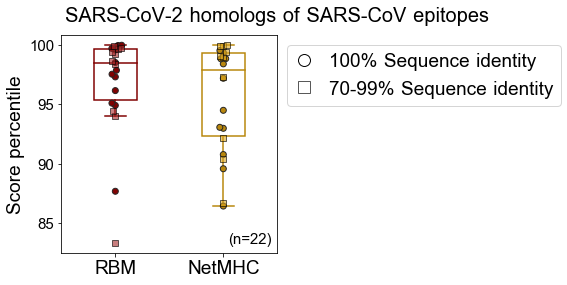

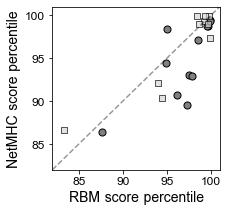

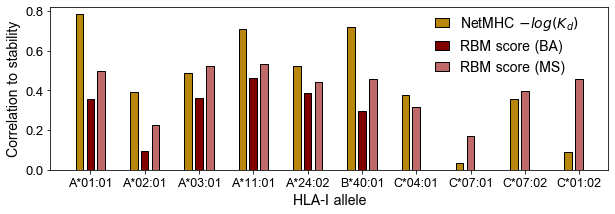

In [43]:
## Fig 1F-G ##

out_fold = rootf + '/data/Allele-specific_models/Allele-specific_COVID19/Results_plot/'
out_fold1 = rootf + '/data/Allele-specific_models/Allele-specific_COVID19/'

freq_hla = ['HLA-A*01:01', 'HLA-A*02:01', 'HLA-A*03:01', 'HLA-A*11:01', 'HLA-A*24:02', 'HLA-B*40:01', 'HLA-C*01:02', 'HLA-C*04:01', 'HLA-C*07:01', 'HLA-C*07:02']
nc = len(freq_hla)  

sars_A_ba = ['KLPDDFTGC', 'SIIAYTMSL','ALNTLVKQL', 'VLNDILSRL', 'LITGRLQSL', 'RLNEVAKNL', 'NLNESLIDL', 
            'FIAGLIAIV', 'TLACFVLAA', 'GLMWLSYFI', 'ALNTPKDHI', 'LQLPQGTTL', 'LALLLLDRL', 'LLLDRLNQL', 'RLNQLESKM', 'GMSRIGMEV',
             'CLEASFNYL', 'WLMWLIINL', 'ILLLDQALV', 'SACVLAAEC', 'SLPGVFCGV', 'TLMNVLTLV', 'SMWALIISV']

sars_A_ba_len = [10,9,9,9,9,9,9,9,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9]
sars_A_ba_mut = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0]
sars_A_ba_cons = [90,89,100,100,100,100,100,100,100,89,100,100,100,100,89,100,56,67,89,56,78,89,89]
sars_A_ba_prot = ['S','S','S','S', 'S', 'S', 'S', 'S', 'M', 'M', 'N', 'N', 'N', 'N', 'N', 'N', 'orf1ab', 'orf1ab', 'orf1ab', 'orf1ab', 'orf1ab', 'orf1ab', 'orf1ab']
sars_A_ba_en = ['NFKDQVILL', 'GDAALALLL']
sars_A_ba_en_mut = [0, 0.5]
sars_A_ba_en_len = [9, 10]
sars_A_ba_en_cons = [78, 80]
sars_A_ba_en_prot = ['N', 'N']
sars_A_ba_en1 = ['NFKDQVILL'] 
sars_A_ba_en2 = ['GDAALALLL'] 
query_sars = sars_A_ba + sars_A_ba_en

## allele-specific case ##
BA=1 ## affinity trained trained ## 
MS=0

#titlep= 'allele-specific models'
names = ['1 A0101', '2 A0201', '3 A0301', '4 A1101', '5 A2402', '6 B4001', '7 C0401', '8 C0701', '9 C0702','10 C0102']
namesF = ['HLA-A*01:01', 'HLA-A*02:01', 'HLA-A*03:01', 'HLA-A*11:01', 'HLA-A*24:02', 'HLA-B*40:01', 'HLA-C*04:01', 'HLA-C*07:01', 'HLA-C*07:02','HLA-C*01:02']
namesl = ['A*01:01', 'A*02:01', 'A*03:01', 'A*11:01', 'A*24:02', 'B*40:01', 'C*04:01', 'C*07:01', 'C*07:02','C*01:02']
lim_sup = [14,15, 41, 49, 30, 30, 1,3,1,3]

C_ms_list = ['7 C0401', '8 C0701', '9 C0702','10 C0102']

clt=[]
rbm_sars=[]

for g in range(len(names)):
    
    list_Rrbm=[]
    list_stabb = []
    list_staa = []
    lrbm_likn = []
    
    filename_lab = out_fold1 + 'Covid19-Intavis-Immunitrack-datasetV2.xlsx'
    cla1 = pd.read_excel(filename_lab, sheet_name=names[g])
    list_sta = (cla1['Sequence'].values)
    list_stab = (cla1['Stab %'].values)
    list_kd = (cla1['Pred Kd (nM)'].values)
    
    if MS == 1:
        filename_lab = out_fold1 + 'covid_' + namesF[g] + '/scoring/covid_9mers_scored_YesReal_0_hu_5_l120.001_AL9.0_SA9_RWYesAlpha_TR1.txt' 

    if BA == 1:      
        if names[g] in C_ms_list:
            filename_lab =  out_fold1 + 'covid_' + namesF[g] + '/scoring/covid_9mers_scored_YesReal_0_hu_5_l120.001_AL9.0_SA9_RWYesAlpha_TR1.txt'  
        else:
            filename_lab = out_fold1 + 'covid_' + namesF[g] + '/scoring/covid_9mers_scored_YesReal_0_hu_5_l120.001_AL9.0_SA9_RWNoAlpha_TR1.txt' 
            
    cla = pd.read_csv(filename_lab, sep='\t')
    
    ll_covid = cla[cla['Length'] == 9]['RBM Log-Lik.'].values/np.log(10)
    seqs_covid = list(cla[cla['Length'] == 9]['Seqs core'].values)
    NAlist = zip(list(np.array(seqs_covid)),ll_covid)
    NArankH = sorted(NAlist, key = lambda x : x[1], reverse=True)
    NAlist2 = zip(list(np.array(seqs_covid)),ll_covid)
    NArankH2 = sorted(NAlist2, key = lambda x : x[1], reverse=True)

    for u in range(len(list_sta)):
        y = seqs_covid.index(list_sta[u])
        list_staa.append(list_sta[u])
        lrbm_likn.append(ll_covid[y])
        y2 = list(np.array(NArankH2)[:,0]).index(list_sta[u])
        list_Rrbm.append(100-(y2+1)*100/(len(seqs_covid)))
        list_stabb.append(list_stab[u])
        
    if names[g] == '2 A0201':
        sars = list(sars_A_ba)
        for u in range(len(sars)):
            y2 = list(np.array(NArankH)[:,0]).index(sars[u])
            rbm_sars.append(100-(y2+1)*100/(len(seqs_covid)))
                
    if names[g] == '5 A2402':
        sars = list(sars_A_ba_en1)
        for u in range(len(sars)):
            y2 = list(np.array(NArankH2)[:,0]).index(sars[u])
            rbm_sars.append(100-(y2+1)*100/(len(seqs_covid)))

            
    if names[g] == '6 B4001':
        sars = list(sars_A_ba_en2)
        for u in range(len(sars)):
            y2 = list(np.array(NArankH2)[:,0]).index(sars[u])
            rbm_sars.append(100-(y2+1)*100/(len(seqs_covid)))
            
    clt.append(np.corrcoef(lrbm_likn, list_stabb)[0,1])
    
BA=0
MS=1 ## mass-spec trained ## 

cltms=[]

for g in range(len(names)):
    
    list_Rrbm=[]
    list_stabb = []
    list_staa = []
    lrbm_likn = []
    
    filename_lab = out_fold1 + 'Covid19-Intavis-Immunitrack-datasetV2.xlsx'
    cla1 = pd.read_excel(filename_lab, sheet_name=names[g])
    list_sta = (cla1['Sequence'].values)
    list_stab = (cla1['Stab %'].values)
    list_kd = (cla1['Pred Kd (nM)'].values)
    
    if MS == 1:
        filename_lab = out_fold1 + 'covid_' + namesF[g] + '/scoring/covid_9mers_scored_YesReal_0_hu_5_l120.001_AL9.0_SA9_RWYesAlpha_TR1.txt' 

    if BA == 1:      
        if names[g] in C_ms_list:
            filename_lab = out_fold1 + 'covid_' + namesF[g] + '/scoring/covid_9mers_scored_YesReal_0_hu_5_l120.001_AL9.0_SA9_RWYesAlpha_TR1.txt'  
        else:
            filename_lab = out_fold1 + 'covid_' + namesF[g] + '/scoring/covid_9mers_scored_YesReal_0_hu_5_l120.001_AL9.0_SA9_RWNoAlpha_TR1.txt' 
            
    cla = pd.read_csv(filename_lab, sep='\t')
    
    ll_covid = cla[cla['Length'] == 9]['RBM Log-Lik.'].values/np.log(10)
    seqs_covid = list(cla[cla['Length'] == 9]['Seqs core'].values)
    NAlist = zip(list(np.array(seqs_covid)),ll_covid)
    NArankH = sorted(NAlist, key = lambda x : x[1], reverse=True)
    NAlist2 = zip(list(np.array(seqs_covid)),ll_covid)
    NArankH2 = sorted(NAlist2, key = lambda x : x[1], reverse=True)

    for u in range(len(list_sta)):
        y = seqs_covid.index(list_sta[u])
        list_staa.append(list_sta[u])
        lrbm_likn.append(ll_covid[y])
        y2 = list(np.array(NArankH2)[:,0]).index(list_sta[u])
        list_Rrbm.append(100-(y2+1)*100/(len(seqs_covid)))
        list_stabb.append(list_stab[u])
        
            
    cltms.append(np.corrcoef(lrbm_likn, list_stabb)[0,1])
    
## upload results from NetMHC ##
nm_sars = np.loadtxt(out_fold + 'nm_sars.txt')

datao = {'Sequence': sars_A_ba + sars_A_ba_en + sars_A_ba + sars_A_ba_en,
        'Protein': sars_A_ba_prot + sars_A_ba_en_prot + sars_A_ba_prot + sars_A_ba_en_prot,
        'Score percentile': rbm_sars + list(nm_sars),
        'Algorithm': list(np.repeat(['RBM', 'NetMHC'],len(rbm_sars))),
        'Identity to SARS': sars_A_ba_cons + sars_A_ba_en_cons + sars_A_ba_cons + sars_A_ba_en_cons, 
        'Length': sars_A_ba_len + sars_A_ba_en_len + sars_A_ba_len + sars_A_ba_en_len,
        'Mut': sars_A_ba_mut + sars_A_ba_en_mut + sars_A_ba_mut + sars_A_ba_en_mut
        }

df = pd.DataFrame (datao, columns = ['Sequence','Protein','Score percentile','Algorithm','Identity to SARS', 'Length', 'Mut'])

#np.savetxt(out_fold + 'correlation_ms.txt', cltms)
#cltms = np.loadtxt(out_fold + 'correlation_ms.txt')
#np.savetxt(out_fold + 'correlation.txt', clt)
#clt = np.loadtxt(out_fold + 'correlation.txt')
#df.to_csv(out_fold + 'Table_results_sars_cov_2.csv')
#df = pd.read_csv(out_fold + 'Table_results_sars_cov_2.csv', sep = ',')

value = df['Identity to SARS'] > 70 # select identity above a certain threshold
fig, ax = plt.subplots()
fig.set_figwidth(8)
st=19
tit = plt.suptitle('SARS-CoV-2 homologs of SARS-CoV epitopes', fontsize = st+1)
sns.boxplot(x = 'Algorithm', y='Score percentile', data=df[value], fliersize=0, ax=ax, width = 0.4)

# iterate over boxes
for i,box in enumerate(ax.artists):
    if i%3==0:
        box.set_edgecolor('Maroon')
        box.set_facecolor('white')
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('Maroon')
    if i%3==1:
        box.set_edgecolor('DarkGoldenRod')
        box.set_facecolor('white')
        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('DarkGoldenRod')
    if i%3==2:
        box.set_edgecolor('DarkGoldenRod')
        box.set_facecolor('white')
        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('DarkGoldenRod')
                
s1 = 6
value1=(df['Identity to SARS'] > 99.9)
sns.swarmplot(x = 'Algorithm', y='Score percentile', data=df[value & value1], linewidth = 1, 
              ax = ax, dodge = 'True', alpha = 0.99, palette=['Maroon', 'DarkGoldenRod','DarkGoldenRod'], s= s1)

value1=(df['Identity to SARS'] < 99.9)
sns.swarmplot(x = 'Algorithm', y='Score percentile', data=df[value & value1], linewidth = 1, 
              ax = ax, dodge = 'True', alpha = 0.6, edgecolor = 'k', palette=['Brown', 'GoldenRod', 'GoldenRod'], s = s1, marker = 's')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

custom_lines =[Line2D([0], [0], marker='o', color='w', markerfacecolor='White', markersize=12, markeredgecolor='k',
markeredgewidth = 1, alpha = 0.99), Line2D([0], [0], marker='s', color='w', markerfacecolor='White',   
    markersize=12, markeredgecolor='k',   markeredgewidth = 1, alpha = 0.65)]
                                                               
lgd = ax.legend(custom_lines, ['100% Sequence identity', '70-99% Sequence identity'], loc='best', bbox_to_anchor=(1, 1) , fontsize=st)

ax.tick_params(axis = 'y', which = 'major', labelsize=st-4)
ax.tick_params(axis = 'x', which = 'major', labelsize=st)
ax.set_xlabel('', fontsize=st)
ax.set_ylabel('Score percentile', fontsize=st)
textst = '(n=22)'
ax.text(0.77, 0.03, textst, transform=ax.transAxes, fontsize=st-4, verticalalignment='bottom')

fig.subplots_adjust(right=0.5)

fig, ax = plt.subplots()
n=3
st=14
fig.set_figwidth(n)
fig.set_figheight(n)

value1=(df['Identity to SARS'] > 99.9)
value2=(df['Mut'] == 0)
sel = (df['Score percentile'][value & value1 & value2].values)
mm=int(len(sel)/2)
listr = sel[:mm]
listn = sel[mm:]
plt.scatter(listr,listn, c='gray', marker='o',edgecolor = 'k', s = 50)

value1=(df['Identity to SARS'] < 99.9)
sel = (df['Score percentile'][value & value1].values)
mm=int(len(sel)/2)
listr = sel[:mm]
listn = sel[mm:]
plt.scatter(listr,listn, c='lightgray', marker = 's', s = 46, edgecolor = 'k', alpha = 0.65)
ax.tick_params(axis = 'both', which = 'major', labelsize=st-2)
ax.set_ylabel('NetMHC score percentile', fontsize=st)
ax.set_xlabel('RBM score percentile', fontsize=st)
v0=82
v1=101
ax.set_xlim([v0,v1])
ax.set_ylim([v0,v1])
ax.plot([v0,v1], [v0,v1], ls = "--", alpha = 0.4, c = 'k')

## Read results from NetMHC ##
cnm = np.loadtxt(out_fold + 'correlation_nm.txt')

namesl = ['A*01:01', 'A*02:01', 'A*03:01', 'A*11:01', 'A*24:02', 'B*40:01', 'C*04:01', 'C*07:01', 'C*07:02','C*01:02']

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(3)
ww2=0.14
st=14
x_post = np.array(range(10))
ax.bar(x_post, cnm, align = 'center', color = 'DarkGoldenRod', width = ww2, label = r'NetMHC $-log(K_d)$', edgecolor = 'k')
ax.bar(x_post[:6] + 0.2, clt[:6], align = 'center', color = 'Maroon', width = ww2, label  = r'RBM score (BA)', edgecolor = 'k')
ax.bar(x_post + np.array(np.hstack((np.repeat(0.4,6),np.repeat(0.2,4)))), cltms, align = 'center', color = [165/255,42/255,42/255,0.7], width = ww2, 
       label  = r'RBM score (MS)', edgecolor = 'k')
ax.set_xticks(x_post+0.2)
ax.legend(markerscale=0.09, frameon=False, loc='upper right', fontsize = st, bbox_to_anchor=(0.97, 1.03))

ax.tick_params(axis = 'both', which = 'major', labelsize=st-1)
ax.set_xticklabels(namesl, rotation = 0, fontsize = st-1.5)
ax.set_xlabel('HLA-I allele', fontsize=st)
ax.set_ylabel('Correlation to stability', fontsize=st)

3. Scoring presentation by A02:01 of neoantigens from Marty et al. 2017

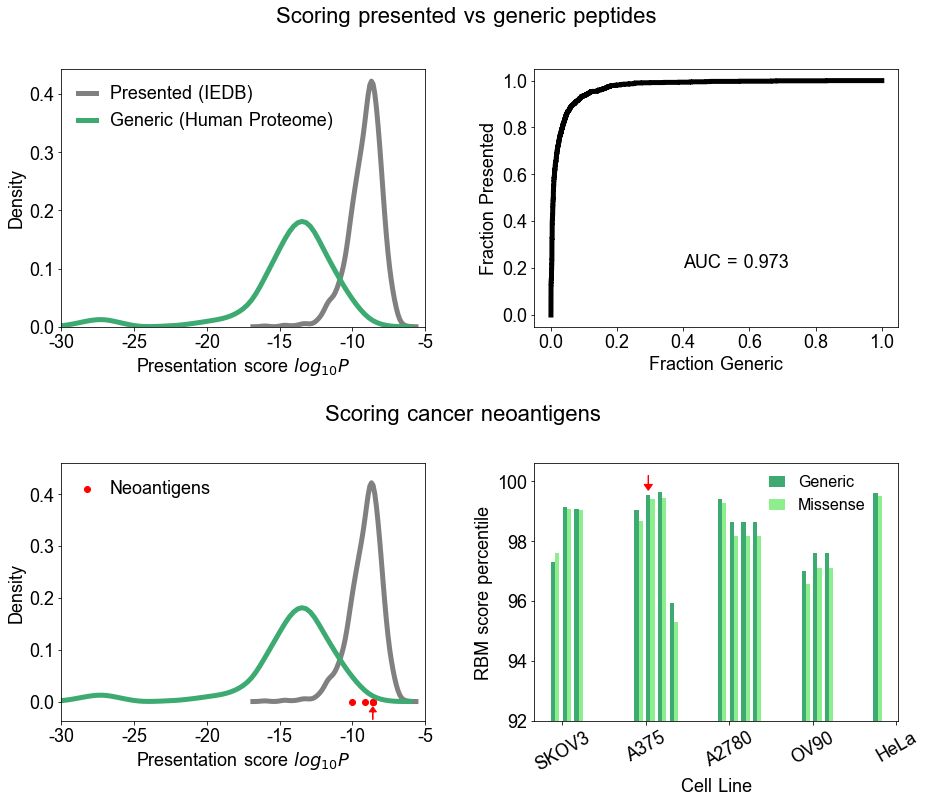

In [5]:
out_fold = rootf + '/data/Allele-specific_models/Neoantigens_HLA-A*02:01/Results_plot/'

## Fig 1C-E: Plots of RBM likelihood for generic sequences, presented antigens and neoantigens from Marty et al. 2017
mpl.rcParams["legend.handlelength"] = 1.0
s2 = 18 
s1=16
ww=0.1

str_cl = ['SKOV3', 'A375', 'A2780', 'OV90', 'HeLa']
c=1
clas = str_cl[c]

list_perc_wes = np.loadtxt(out_fold + 'list_perc_wes.txt')
list_perc = np.loadtxt(out_fold + 'list_perc.txt')
list_coord = np.loadtxt(out_fold + 'list_coord.txt')
list_coord_wes = np.loadtxt(out_fold + 'list_coord_wes.txt')
lr = np.loadtxt(out_fold + 'lr_5_0.001_mon.txt')/np.log(10)
lv = np.loadtxt(out_fold + 'lv_5_0.001_mon.txt')/np.log(10)
lrbm_likn = np.loadtxt(out_fold + 'lrbm_lik_5_0.001_mon_' + clas + '.txt')/np.log(10)

labels = np.hstack((np.ones((len(lv))), np.zeros((len(lr)))))
scores = np.hstack((lv, lr))
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)

w=5
colors = ['r','orange', 'deepskyblue', 'blue', (100/255, 220/255, 0), 'forestgreen']

fig, axf = plt.subplots(2,2)
fig.set_figheight(12)
fig.set_figwidth(15)
plt.subplots_adjust(wspace = 0.3, hspace = 0.53)
plt.figtext(0.5, 0.94, 'Scoring presented vs generic peptides', ha='center', va='center', fontsize = 22)
plt.figtext(0.5, 0.48, 'Scoring cancer neoantigens ', ha='center', va='center', fontsize = 22)

ax = axf[0,0]
sns.distplot(lv, hist = False, kde_kws = {'linewidth': w}, color = 'gray', label = 'Presented (IEDB)', ax = ax)
sns.distplot(lr, hist = False, kde_kws = {'linewidth': w}, color =  (60/255, 170/255, 113/255), label = 'Generic (Human Proteome)', ax = ax)
ax.set_xlabel(r'Presentation score $log_{10} P$', fontsize=s2)
ax.set_ylabel('Density', fontsize=s2)
ax.legend(fontsize=s2, markerscale=3, frameon=False, loc='upper left')
ax.tick_params(axis = 'both', which = 'major', labelsize=s2)
ax.set_xlim([-30,-5])

ax = axf[0,1]
ax.plot(fpr,tpr,lw=w,color='k')
ax.set_xlabel('Fraction Generic', fontsize=s2)
ax.set_ylabel('Fraction Presented', fontsize=s2)
ax.tick_params(axis='both', which='major', labelsize=s2)
ax.text(0.4, 0.2, 'AUC = ' + format(metrics.auc(fpr, tpr), '.3f'), fontsize=s2)

p=1
ax = axf[1,0]
sns.distplot(lv, hist = False, kde_kws = {'linewidth': w, 'alpha':1}, color = 'gray', ax = ax)
sns.distplot(lr, hist = False, kde_kws = {'linewidth': w,  'alpha':1}, color =  (60/255, 170/255, 113/255), ax = ax)
ax.set_xlabel(r'Presentation score $log_{10} P$', fontsize=s2)
ax.set_ylabel('Density', fontsize=s2)
ax.tick_params(axis='both', which='major', labelsize=s2)
ax.set_ylim([-0.038,0.46])
#ax.set_title('Cell line ' + clas, fontsize = s2)
ax.arrow(lrbm_likn[p], -0.035, 0, 0.015, color = 'r', head_width=0.5, head_length=0.01, shape='full', zorder=6)
ax.set_xlim([-30,-5])
ax.scatter(lrbm_likn[p], 0, color = 'r', label = 'Neoantigens')
for f in range(len(lrbm_likn)):
    ax.scatter(lrbm_likn[f], 0, color = 'r')
ax.legend(fontsize=s2, markerscale=1, frameon=False, loc='upper left')
    
ax = axf[1,1]
ppwes = np.array(list_perc_wes)
pp = np.array(list_perc)
x_post = np.array([1,3,5,7,9])
ax.set_xticks(x_post + 0.5)
ax.set_xticklabels(str_cl, rotation = 30, fontsize = s2)
x_pos = np.array(list_coord)
ax.bar(x_pos, 100 - pp, align = 'center', color = (60/255, 170/255, 113/255), width = ww, label = 'Generic')
x_pos = np.array(list_coord_wes)
ax.bar(x_pos, 100 - ppwes, align = 'center', color = (140/255, 238/255, 140/255), width = ww, label = 'Missense')
ax.set_ylabel('RBM score percentile', fontsize = s2)
ax.set_xlabel('Cell Line', fontsize = s2)
ax.legend(fontsize=s1, markerscale=0.1, frameon=False, loc='best', bbox_to_anchor=(0.45, 0.51, 0.5, 0.5))
ax.set_ylim([92,100.6])
ax.tick_params(axis='both', which='major', labelsize=s2)
ax.arrow(list_coord[5], 100.2, 0, -0.3, color = 'r', head_width=0.2, head_length=0.2, shape='full', zorder=6);